In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [2]:
match = pd.read_csv('matches.csv')

In [3]:
null_col = match.isnull().sum()
print(null_col[null_col > 0])

city                 7
winner               4
player_of_match      4
umpire1              2
umpire2              2
umpire3            637
dtype: int64


In [4]:
match = match[match["winner"].notna()]
match

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,2017,Indore,2017-04-08,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,2017,Bangalore,2017-04-08,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,2019,Mumbai,05/05/19,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi
752,11412,2019,Chennai,07/05/19,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould
753,11413,2019,Visakhapatnam,08/05/19,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN
754,11414,2019,Visakhapatnam,10/05/19,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin


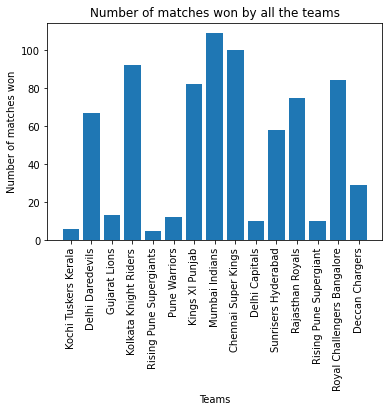

In [5]:
team = list(set(match.loc[:,"team1"]))
won_matches = [len(match.loc[match['winner'] == i]) for i in team]
plt.bar(np.arange(len(team)) , won_matches)
plt.xticks(np.arange(len(team)) , team , rotation = "vertical")
plt.xlabel("Teams")
plt.ylabel("Number of matches won")
plt.title("Number of matches won by all the teams")
plt.show()

In [6]:
encoder = LabelEncoder()
match["team1"] = encoder.fit_transform(match["team1"])
match["team2"] = encoder.fit_transform(match["team2"])
match["winner"] = encoder.fit_transform(match["winner"].astype(str))
match["toss_winner"] = encoder.fit_transform(match["toss_winner"])
match["venue"] = encoder.fit_transform(match["venue"])

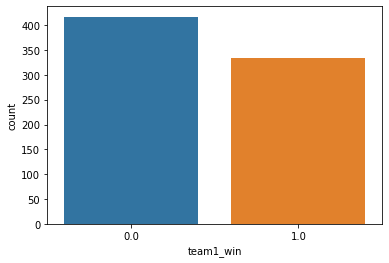

In [7]:
match.loc[match["winner"] == match["team1"], "team1_win"] = 1
match.loc[match["winner"] != match["team1"], "team1_win"] = 0

match.loc[match["toss_winner"] == match["team1"], "team1_toss_win"] = 1
match.loc[match["toss_winner"] != match["team1"], "team1_toss_win"] = 0

match["team1_bat"] = 0
match.loc[(match["team1_toss_win"] == 1) & (match["toss_decision"] == "bat") , "team1_bat"] = 1

sns.countplot(x = "team1_win" , data = match)
plt.show

prediction_df = match[["team1" , "team2" , "team1_toss_win" , "team1_bat" , "team1_win" , "venue"]]

In [8]:
correlated_features = set()
correlation_matrix = prediction_df.drop("team1_win" , axis=1).corr()
correlation_matrix

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i , j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
prediction_df.drop(columns = correlated_features)

,team1,team2,team1_toss_win,team1_win,venue
0,14,13,0.0,1.0,28
1,8,11,0.0,0.0,21
2,4,7,0.0,0.0,31
3,11,5,0.0,0.0,13
4,13,3,1.0,1.0,17
...,...,...,...,...,...
751,7,8,0.0,0.0,40
752,0,8,1.0,0.0,18
753,14,2,0.0,0.0,0
754,2,0,0.0,0.0,0


In [9]:
X = prediction_df.drop("team1_win" , axis = 1)
target = prediction_df["team1_win"]
target = target.astype(int)

In [10]:
X_train , X_test , y_train , y_test = train_test_split(X , target , test_size=0.2 , random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [11]:
svm = SVC()
svm.fit(X_train , y_train)
svm.score(X_test , y_test)
y_pred = svm.predict(X_test)
print(confusion_matrix(y_test , y_pred))
print(classification_report(y_pred , y_pred))
print("Accuracy : {:.4f}" .format(svm.score(X_test , y_test)) )

[[93  2]
 [48  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       141
           1       1.00      1.00      1.00        10

    accuracy                           1.00       151
   macro avg       1.00      1.00      1.00       151
weighted avg       1.00      1.00      1.00       151

Accuracy : 0.6689
